(vqc)=

# Вариационные квантовые схемы

## Описание лекции

На этой лекции мы впервые познакомимся непосредственно с квантовым машинным обучением. Теперь вместо `NumPy` мы будем использовать `PennyLane`. Лекция расскажет:

- в чем заключается идея квантово-классического обучения;
- что такое вариационное машинное обучение;
- как устроена вариационная квантовая схема и как закодировать в нее данные.

## Введение

В течение всего курса мы будем говорить преимущественно о комбинированном квантово-классическом машинном обучении, построенном на базе вариационных квантовых схем. Именно он является наиболее перспективным в эпоху {term}`NISQ<"Шумные" квантовые компьютеры промежуточного масштаба>`. Давайте забежим немного вперед и посмотрим, как выглядит типичный цикл такого обучения.

```{figure} /_static/vqcblock/vqc/diagram.png
:name: vqcdiag
:height: 400px

Пример цикла смешанного обучения
```

Красным цветом на диаграмме помечены блоки, выполняемые на квантовом устройстве, зеленым -- те, что считает обычный компьютер. Квантовая часть, которая включает в себя операторы $\hat{U(X)}$ и $\hat{U(\theta})$, а также измерение наблюдаемой $\hat{M}$, называется вариационной квантовой схемой. Именно ей посвящена данная лекция.

Но сначала сделаем шаг назад и обсудим в общих чертах идеи, которые лежат в основе квантово-классического обучения.

## Квантово-классическое обучение

Основная идея квантово-классического обучения заключается в том, что в эпоху Noise Intermediate Scale Quantum (_NISQ_) у нас нет больших работающих квантовых компьютеров и квантовой памяти. Это сильно ограничивает применение алгоритмов, более быстрых, чем классические. Нам остается только "встраивать" квантовые схемы в классический цикл обучения.

В этом случае мы разделяем классическую и квантовую части алгоритма. Выполняем предварительную обработку и подготовку данных на классическом компьютере, затем "прогоняем" их через квантовую схему. Она должна возвращать нам "классические" данные, а значит, должна включать в себя набор последовательно применяемых операторов и измерение. Со стороны классического компьютера такая схема выглядит как "черный ящик" или "оракул", с которым уже можно работать. Например, можно варьировать параметры схемы таким образом, чтобы она "обучалась" так же, как "обучаются" нейронные сети или другие алгоритмы классического машинного обучения.

Давайте более детально посмотрим на квантовую схему, которую можно использовать в таком подходе.

## Вариационные квантовые схемы

В основе вариационных квантовых схем -- Variational Quantum Circuits (**VQC**) -- лежит простая идея. Чтобы проиллюстрировать ее, давайте сделаем схему, которая включает в себя набор унитарных операторов и переводит классические данные $\mathbf{X}$ и параметры $\theta$ в квантовое состояние $\ket{\Psi}(\theta, \mathbf{X})$. Затем будем варьировать наше состояние $\ket{\Psi}$, меняя параметры $\theta$ так, чтобы при его измерении в каком-либо базисе мы получали нужный результат, например, результат классификации входных данных $\mathbf{X}$.

Разберем написанное выше на примере.

### Аппроксимация {term}`матрицы Паули<Операторы Паули>` **X** оператором поворота

Из предыдущих лекций мы помним, что оператор $\hat{\mathbf{X}}$ работает как квантовый аналог оператора =NOT= -- инвертирует значение кубита.

In [1]:
import pennylane as qml

dev = qml.device("default.qubit", 1)

@qml.qnode(dev)
def simple_x_gate():
    qml.PauliX(0)
    return qml.expval(qml.PauliZ(0))


print(simple_x_gate())

print(simple_x_gate.draw())

-1.0
 0: ──X──┤ ⟨Z⟩ 



```{note}
Тут мы измеряем наш кубит в $\mathbf{Z}$-базисе и чаще всего будем измерять именно в нем. $\mathbf{Z}$-базис является неким "стандартом" для квантовых вычислений, так как это измерение "ближе к железу". Также $\mathbf{Z}$-базис удобен для нас из-за диагональности {term}`оператора Паули<Операторы Паули>` $\sigma^z$.
```

С другой стороны, у нас есть оператор $\hat{RX}(\phi)$, который "вращает" состояние нашего кубита вокруг оси $\mathbf{X}$ на угол $\phi$. Сделаем параметризованную схему с одним параметром:

In [2]:
@qml.qnode(dev)
def vqc(phi):
    qml.RX(phi, wires=[0])
    return qml.expval(qml.PauliZ(0))

Теперь попробуем подобрать $\phi$ так, чтобы параметризованная схема работала точно так же, как оператор $\hat{X}$:

In [3]:
print(f"Try 1.0: {vqc(0)}")
print(f"Try 2.0: {vqc(2)}")
print(f"Try 3.0: {vqc(3)}")
print(f"Try 3.14159265359: {vqc(3.14159265359)}")

Try 1.0: 1.0
Try 2.0: -0.4161468365471423
Try 3.0: -0.9899924966004454
Try 3.14159265359: -1.0


Получается, что нужный нам угол $\phi$ составляет ровно $\pi$. Это логично, мы могли бы это легко понять из простейших соображений линейной алгебры, либо взглянув на сферу Блоха. Но целью этого примера было проиллюстрировать работу VQC.

Наш процесс "подбора" параметра $\phi$ крайне примитивный, но следующую лекцию мы полностью посвятим тому, как посчитать градиент параметров квантовой схемы и задействовать всю мощь известных на сегодня методов оптимизации. А пока еще немного подумаем о том, как можно закодировать данные в квантовую схему.

## Кодирование данных в VQC

В конструировании VQC есть две важных части:

- кодирование классических данных в квантовые операторы;
- выбор наблюдаемой для измерений.

Вот как можно закодировать данные.

### Кодирование поворотами

Один из самых популярных методов кодирования классических данных в квантовые схемы -- это использование операторов поворота $\hat{RY}, \hat{RZ}$. Представим, что мы хотим отображать вектор из двумерного пространства в один кубит $\vec{x} \in \mathbb{R}^2 \to \mathbb{C}^2$.

In [4]:
@qml.qnode(dev)
def angle_vqc(a, b):
    qml.RY(a, wires=[0])
    qml.RZ(b, wires=[0])

    return qml.expval(qml.PauliZ(0))

А теперь давайте посмотрим, как такая схема преобразует данные. Для этого сгенерируем набор случайных двумерных данных в диапазоне $[0, 2\pi]$ и применим к каждой точке нашей схемы, затем визуализируем результаты:

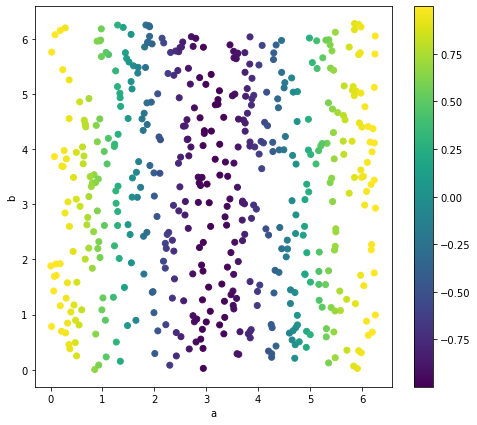

In [5]:
import numpy as np
import matplotlib.pyplot as plt

aa = np.random.uniform(0, 2 * np.pi, size=500)
bb = np.random.uniform(0, 2 * np.pi, size=500)

res = [angle_vqc(a, b) for a, b in zip(aa, bb)]

f = plt.figure(figsize=(8, 7))
clb = plt.scatter(aa, bb, c=res)
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(clb)

f.show()

Результат довольно необычный. Предсказать такое довольно сложно и хорошо видна возможность нелинейности `VQC` схем. В дальнейших лекциях мы будем более подробно разбирать возможные варианты кодирования данных. Кстати, кодирование углами настолько популярно, что в `PennyLane` для этого есть специальная функция, которая позволяет "повернуть" сразу множество кубитов, используя список из классических данных:

In [6]:
@qml.qnode(dev)
def angle_vqc_pl(a, b):
    qml.templates.embeddings.AngleEmbedding([a], wires=[0], rotation="Y")
    qml.templates.embeddings.AngleEmbedding([b], wires=[0], rotation="Z")
    return qml.expval(qml.PauliZ(0))

Давайте убедимся, что это даст нам ровно тот же результат:

In [7]:
res_pl = [angle_vqc_pl(a, b) for a, b in zip(aa, bb)]
print(np.allclose(res, res_pl))

True


### Важность многокубитных гейтов

При кодировании параметров целесообразно использовать многокубитные гейты, так как именно они создают запутанные состояния и раскрывают все преимущества квантовых компьютеров. Давайте попробуем это сделать.

In [8]:
dev2 = qml.device("default.qubit", 2)

@qml.qnode(dev2)
def cnot_vqc(a, b):
    qml.RY(a, wires=0)
    qml.RY(b, wires=1)
    qml.RZ(a, wires=0)
    qml.RZ(b, wires=1)
    qml.CZ(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

В этой схеме мы видим оператор $\hat{CZ}$, который создает запутанное состояние. Посмотрим, как такая схема преобразует наше исходное пространство случайных точек.

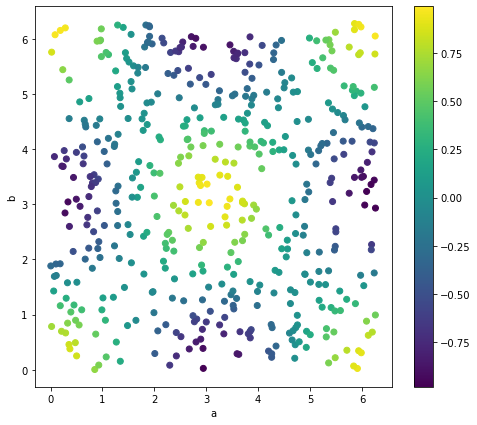

In [9]:
res = [cnot_vqc(a, b) for a, b in zip(aa, bb)]

f = plt.figure(figsize=(8, 7))
clb = plt.scatter(aa, bb, c=res)
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(clb)

plt.show()

Результат выглядит гораздо интереснее. В целом можно сказать, что выбор способа кодирования данных -- один из важнейших при проектировании **VQC**. Мы еще много раз будем обсуждать способы сделать это.

## Что мы узнали из лекции

- В эпоху NISQ эпоху мы чаще всего ограничены комбинированием квантового и классического машинного обучения.
- Ключевой элемент такого обучения -- вариационные квантовые схемы (VQC). Основная идея VQC:
  - кодируем классические данные в квантовые операторы;
  - измеряем состояние;
  - варьируем параметры на классическом компьютере так, чтобы измерение давало желаемый результат.
- Один из широко применимых методов кодирования -- использование операторов вращений $\hat{RX}, \hat{RY}, \hat{RZ}$